# Processing Echosounder Data using `echopype`

**Authors:** Wu-Jung Lee, Landungs "Don" Setiawan, and Valentina Staneva

In this notebook we demonstrate how to process echosounder data using `echopype` version `0.5.0`.

We will use data from the Ocean Observatories Initiative (OOI) [Oregon Offshore Cabled Shallow Profiler Mooring](https://oceanobservatories.org/site/ce04osps/) collected on August 20-21, 2017. This was the day before and of the solar eclipse, during which the reduced sunlight affected the regular diel vertical migration (DVM) patterns of marine life. This change was directly observed using a moored, upward-looking echosounder that happened to be within the totality zone.

## Examine the workflow by processing just one file

Let's first test `echopype` by converting and processing 1 file from an [Simrad EK60 echosounder](https://www.kongsberg.com/maritime/products/ocean-science/fishery-research/es_scientific/simrad-ek60/). 

On the OOI network there are only two EK60 echosounders located on the Regional Cabled Array. All other echosounders are the [Acoustic Zooplankton and Fisher Profiler (AZFP)](https://aslenv.com/azfp.html) manufacturered by ASL Environmental Sciences. Echopype supports both of these and other instruments (see [echopype documentation](https://echopype.readthedocs.io/en/stable/index.html) for detail).

### Converting from raw data files to a standardized data format

Echopype supports reading files hosted on an **http server** or **amazon s3 bucket object storage** directly using the function `open_raw`. In the example below, we will parse a single raw file from the OOI Raw Data Archive.

In [1]:
from pathlib import Path
import itertools as it
import datetime as dt
from dateutil import parser as dtparser

import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Note: we encourage importing `echopype` as `ep` for consistency.

Below we already know the path to the 1 file on the http server:

In [2]:
file_url = (
    "https://rawdata.oceanobservatories.org/files/"
    "CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/21/"
    "OOI-D20170821-T163049.raw"
)

In [3]:
echodata = ep.open_raw(raw_file=file_url, sonar_model="ek60")

21:22:03  parsing file OOI-D20170821-T163049.raw, time of first ping: 2017-Aug-21 16:30:49


Echopype will read, parse, and convert the raw file in memory, then gives you a nice representation of the converted file below as a Python `EchoData` object.

In [4]:
echodata

EchoData: standardized raw data from Internal Memory
  > top: (Top-level) contains metadata about the SONAR-netCDF4 file format.
  > environment: (Environment) contains information relevant to acoustic propagation through water.
  > platform: (Platform) contains information about the platform on which the sonar is installed.
  > provenance: (Provenance) contains metadata about how the SONAR-netCDF4 version of the data were obtained.
  > sonar: (Sonar) contains specific metadata for the sonar system.
  > beam: (Beam) contains backscatter data and other beam or channel-specific data.
  > vendor: (Vendor specific) contains vendor-specific information about the sonar and the data.

Echopype supports saving the parsed data encapsulated in the `EchoData` object to either a `netCDF4` or `zarr` file formats through the `to_netcdf` or `to_zarr` methods:

### Basic processing functionalities

At present `echopype` supports basic processing funcionalities including calibration (from raw instrument data records to volume backscattering strength, $S_V$), denoising, and computing mean volume backscattering strength, $\overline{S_V}$ or $\text{MVBS}$. The `Echodata` object can be passed into various calibrate and preprocessing functions without having to write out any intermediate files.

Here we demonstrate calibration to obtain $S_V$. For EK60 data, by default the calibration uses environmental (sound speed and absorption) and calibration parameters stored in the data file. Users can optionally specify these parameters to be used in calibration.

In [5]:
ds_Sv = ep.calibrate.compute_Sv(echodata) # Compute volume backscattering strength (Sv) from raw data.

In [6]:
ds_Sv

<xarray.Dataset>
Dimensions:                (frequency: 3, ping_time: 5923, range_bin: 1072)
Coordinates:
  * frequency              (frequency) float64 3.8e+04 1.2e+05 2e+05
  * ping_time              (ping_time) datetime64[ns] 2017-08-21T16:30:49.164...
  * range_bin              (range_bin) int64 0 1 2 3 4 ... 1068 1069 1070 1071
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 3.827 .....
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            object None
    salinity               object None
    pressure               object None
    sound_speed            (frequency, ping_time) float64 1.494e+03 ... 1.494...
    sound_absorption       (frequency, ping_time) float64 0.009785 ... 0.05269
    sa_correction          (frequency) float64 0.0 0.0 0.0
    gain_correction        (frequency) float64 26.5 25.0 25.0
    equivalent_beam_angle  (frequency) float64 -20.6 -20.7 -20.7

### Visualizing the result

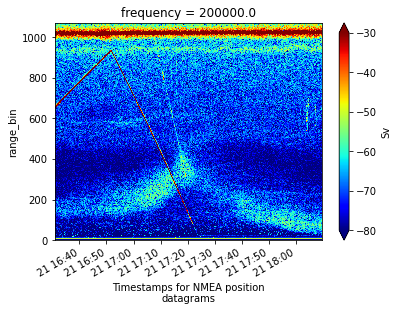

In [7]:
ds_Sv.Sv.sel(frequency=200000).plot.pcolormesh(
    x='ping_time', cmap = 'jet', vmin=-80, vmax=-30);

## Process multiple files with echopype

Now that we verified that `echopype` does work, let's proceed to process all sonar data from August 20-21, 2017.

To retrieve multiple files from the OOI http server we will use the `fsspec` package. 

The `fsspec` package supports many local and remote filesystems. Since we will be accessing the OOI raw data archive, which is hosted in an `http` server, let's setup our http filesystem.

In [8]:
fs = fsspec.filesystem('https')

In [9]:
ooi_raw_url = (
    "https://rawdata.oceanobservatories.org/files/"
    "CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08"
)

Now let's specify the range of dates we will be pulling data from. Note that the data filenames contain the time information but were recorded at UTC time.

In [10]:
def in_range(raw_file: str, start: dt.datetime, end: dt.datetime) -> bool:
    """Check if file url is in date range"""
    file_name = Path(raw_file).name
    # file_name = os.path.basename(raw_file)
    file_datetime = dtparser.parse(file_name, fuzzy=True)
    return file_datetime >= start and file_datetime <= end

In [11]:
start_datetime = dt.datetime(2017, 8, 20, 6, 0)
end_datetime = dt.datetime(2017, 8, 22, 7, 0)

On the OOI Raw Data Archive, the monthly folder is further split to daily folders, so we can simply grab data from the desired days.

In [12]:
desired_day_urls = [f"{ooi_raw_url}/{day}" for day in range(start_datetime.day, end_datetime.day + 1)]

In [13]:
desired_day_urls

['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/20',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/21',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22']

Grab all raw files within daily folders by using the filesytem glob, just like the Linux `glob`.

In [14]:
all_raw_file_urls = it.chain.from_iterable([fs.glob(f"{day_url}/*.raw") for day_url in desired_day_urls])

In [15]:
desired_raw_file_urls = list(filter(
    lambda raw_file: in_range(raw_file, start_datetime, end_datetime), all_raw_file_urls
))

print(f"There are {len(desired_raw_file_urls)} raw files to be converted.")

There are 31 raw files to be converted.


### Parse the raw files and export to disk in a standardized format

Since each files can be large, we will read, convert, and write the converted data to netCDF files locally.

1. Let's first create a designated folder for these files, `exports/ooimooring_calibratednc`

In [16]:
base_dpath = Path('./exports')
base_dpath.mkdir(exist_ok=True)

calibrated_dpath = (base_dpath / 'ooimooring_calibratednc')
calibrated_dpath.mkdir(exist_ok=True)

2. Now the folder is setup, we can go ahead to convert and export data.

**NOTE: The operations below will take some time (possibly up to 30 min), so go ahead and get a cup of coffee while waiting :)**

In [17]:
%%time
for raw_file_url in desired_raw_file_urls:
    # Read and convert, resulting in echodata object
    ed = ep.open_raw(raw_file=raw_file_url, sonar_model='ek60')
    
    # Compute volume backscattering strength (Sv) from converted echodata objects
    ds_Sv = ep.calibrate.compute_Sv(ed)
    
    # Write the Sv dataset to file
    ds_Sv.to_netcdf(calibrated_dpath / f"{Path(raw_file_url).stem}_Sv.nc")

### Open and visualize the results by concatenating (combining)  the individual files

Now that all files are in an appropriate format, we can open them and visualize them by first concatenating the individual files along the `ping_time` dimension.

In [18]:
sv_files = sorted([sv_file for sv_file in calibrated_dpath.glob('*_Sv.nc')])

In [19]:
ds_Sv = xr.open_mfdataset(
    sv_files, 
    concat_dim='ping_time', 
    data_vars='minimal'
)

In [20]:
ds_Sv

<xarray.Dataset>
Dimensions:                (frequency: 3, ping_time: 177536, range_bin: 1072)
Coordinates:
  * frequency              (frequency) float64 3.8e+04 1.2e+05 2e+05
  * ping_time              (ping_time) datetime64[ns] 2017-08-20T06:35:50.111...
  * range_bin              (range_bin) int64 0 1 2 3 4 ... 1068 1069 1070 1071
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 5923, 1072), meta=np.ndarray>
    range                  (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 5923, 1072), meta=np.ndarray>
    temperature            float64 nan
    salinity               float64 nan
    pressure               float64 nan
    sound_speed            (frequency, ping_time) float64 dask.array<chunksize=(3, 5923), meta=np.ndarray>
    sound_absorption       (frequency, ping_time) float64 dask.array<chunksize=(3, 5923), meta=np.ndarray>
    sa_correction          (frequency) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    gain_correction        (frequency) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    equivalent_beam_angle  (frequency) float64 dask.array<chunksize=(3,), meta=np.ndarray>

Since the echosounder was mounted on a mid-water moored platform looking upward, we need to flip the range coordinate to construct a depth coordinate.

In [21]:
ds_Sv.coords['depth'] = (['frequency', 'range_bin'], ds_Sv.range.isel(ping_time=0).data[...,::-1])

In [22]:
ds_Sv['depth'] = ds_Sv.depth.assign_attrs({'units': 'm', 'long_name': 'Depth'})

Let's slice out and visualize only data from the 200 kHz channel. This echosounder contains 3 narrowband frequency channels, at 38, 120, and 200 kHz. We choose the 200 kHz data here because it captured the zooplankton distribution well.

In [23]:
sv_200k = ds_Sv.sel(frequency=200000)

In [24]:
sv_200k = sv_200k.swap_dims({'range_bin': 'depth'})  # set depth as data dimension

In [25]:
sv_200k.hvplot.image(
    x='ping_time', y='depth', 
    color='Sv', rasterize=True, 
    cmap='jet', clim=(-80, -30)
).options({'Image': dict(width=800, invert_yaxis=True)})

:DynamicMap   []
   :Image   [ping_time,depth]   (Sv)

Note that the reflection from the sea surface shows up at a location below the depth of 0 m. This is because we have not corrected for the actual depth of the platform on which the echosounder is mounted, and the actual sound speed at the time of data collection (which is related to the calculated range) could also be different from the user-defined sound speed stored in the data file. More accurate platform depth information can be obtained using data from the CTD collocated on the moored platform.

## Access solar radiation measurements from an OOI mooring

Now we have the sonar data ready, the next step is to pull solar radiation data collected by a nearby surface mooring also maintained by the OOI. The Bulk Meteorology Instrument Package is located on the [Coastal Endurance Oregon Offshore Surface Mooring](https://oceanobservatories.org/site/ce04ossm/). 

Note: an earlier version of this notebook used the same dataset but pulled from the National Data Buoy Center (NDBC). We thank the Rutgers OOI Data Lab for pointing out the direct data source in [one of the data nuggets](https://datalab.marine.rutgers.edu/data-nuggets/zooplankton-eclipse/).

In [26]:
metbk_url = (
    "http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/"
    "CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/"
    "deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170421T022518.003000-20171013T154805.602000.nc#fillmismatch"
)

In [27]:
metbk_ds = (
    xr.open_dataset(metbk_url)
    .swap_dims({'obs': 'time'})
    .drop('obs')
    .sel(time=slice(start_datetime, end_datetime))[['shortwave_irradiance']]
)
metbk_ds.time.attrs.update({'long_name': 'Time', 'units': 'UTC'})

metbk_ds

<xarray.Dataset>
Dimensions:               (time: 2941)
Coordinates:
  * time                  (time) datetime64[ns] 2017-08-20T06:00:14.767999488...
Data variables:
    shortwave_irradiance  (time) float32 ...
Attributes:
    node:                               SBD11
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             metbk_a_dcl_instrument_recovered
    featureType:                        point
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2020-08-16T19:32:33.907683
    keywords:                           
    cdm_data_type:                      Point
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2020-08-16T19:32:33.907675
    id:                                 CE04OSSM-SBD11-06-METBKA000-recovered...
    requestUUID:                        4ef40a13-fec1-4b3a-80b7-d5efa5f26ad7
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:                
    institution:                        Ocean Observatories Initiative
    naming_authority:                   org.oceanobservatories
    feature_Type:                       point
    infoUrl:                            http://oceanobservatories.org/
    license:                            
    contributor_name:                   
    uuid:                               4ef40a13-fec1-4b3a-80b7-d5efa5f26ad7
    creator_name:                       Ocean Observatories Initiative
    title:                              Data produced by Stream Engine versio...
    sensor:                             06-METBKA000
    standard_name_vocabulary:           NetCDF Climate and Forecast (CF) Meta...
    acknowledgement:                    
    Conventions:                        CF-1.6
    project:                            Ocean Observatories Initiative
    source:                             CE04OSSM-SBD11-06-METBKA000-recovered...
    publisher_url:                      http://oceanobservatories.org/
    creator_url:                        http://oceanobservatories.org/
    nodc_template_version:              NODC_NetCDF_TimeSeries_Orthogonal_Tem...
    subsite:                            CE04OSSM
    processing_level:                   L2
    history:                            2020-08-16T19:32:33.907617 generated ...
    Manufacturer:                       Star Engineering
    ModelNumber:                        ASIMET
    SerialNumber:                       LGR032
    Description:                        Bulk Meteorology Instrument Package: ...
    FirmwareVersion:                    Not specified.
    SoftwareVersion:                    Not specified.
    AssetUniqueID:                      CGINS-METLGR-00032
    Notes:                              Not specified.
    Owner:                              Oregon State University
    RemoteResources:                    []
    ShelfLifeExpirationDate:            Not specified.
    Mobile:                             False
    AssetManagementRecordLastModified:  2020-08-14T18:41:26.311000
    time_coverage_start:                2017-04-21T02:25:18.003000
    time_coverage_end:                  2017-10-13T15:48:05.602000
    time_coverage_resolution:           P60.00S
    geospatial_lat_min:                 44.36555
    geospatial_lat_max:                 44.36555
    geospatial_lat_units:               degrees_north
    geospatial_lat_resolution:          0.1
    geospatial_lon_min:                 -124.9407
    geospatial_lon_max:                 -124.9407
    geospatial_lon_units:               degrees_east
    

## Combine sonar observation with solar radiation measurements

We can finally put everything together and figure out the impact of the eclipse-driven reduction in sunlight on marine zooplankton!

In [28]:
metbk_plot = metbk_ds.hvplot.line(
    x='time', y='shortwave_irradiance'
).options(width=800, height=300, logy=True, xlim=(start_datetime, end_datetime))
sv_plot = sv_200k.hvplot.image(
    x='ping_time', y='depth', 
    color='Sv', rasterize=True, 
    cmap='jet', clim=(-80, -30)
).options({'Image': dict(width=800, invert_yaxis=True, xlim=(start_datetime, end_datetime))})

In [29]:
(metbk_plot + sv_plot).cols(1)

NameError: name 'pandas_datetime_types' is not defined

:Layout
   .Curve.I      :Curve   [time]   (shortwave_irradiance)
   .DynamicMap.I :DynamicMap   []
      :Image   [ping_time,depth]   (Sv)

Look how the dip at solar radiation reading matches exactly with the upwarding moving "blip" at UTC 17:21, August 22, 2017 (local time 10:22 AM), whereas on the previous day, the animals underwent the regular DVM cycle. During the solar eclipse, the animals were fooled by the temporary mask of the sun and thought it's getting dark as at dusk!

## Package versions

In [30]:
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, hvplot: {hvplot.__version__}, fsspec: {fsspec.__version__}")

echopype: 0.5.0, xarray: 0.16.2, hvplot: 0.7.2, fsspec: 0.8.7


In [31]:
import datetime
print(f"{datetime.datetime.utcnow()} +00:00")

2021-07-14 04:23:21.072399 +00:00
